# Collaborative Filtering Movie Recommendation System

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

### Data Exploration and Preprocessing

#### Load the Data

In [55]:
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='ISO-8859-1', usecols=[0, 1], names=['movie_id', 'title'])

In [57]:
print(ratings.head())
print(movies.head())

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
   movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)


In [59]:
merged_data = pd.merge(ratings, movies, on='movie_id')
print(merged_data.head())

   user_id  movie_id  rating  timestamp                       title
0      196       242       3  881250949                Kolya (1996)
1      186       302       3  891717742    L.A. Confidential (1997)
2       22       377       1  878887116         Heavyweights (1994)
3      244        51       2  880606923  Legends of the Fall (1994)
4      166       346       1  886397596         Jackie Brown (1997)


#### Understand the Data Structure

In [62]:
num_users = ratings['user_id'].nunique()
num_movie=movies['movie_id'].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique Movies: {num_movie}")


Number of unique users: 943
Number of unique Movies: 1682


In [64]:
# Check for null values
print(ratings.isnull().sum())

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64


### Basic Exploratory Data Analysis

#### Distribution of Ratings, Most Rated Movies

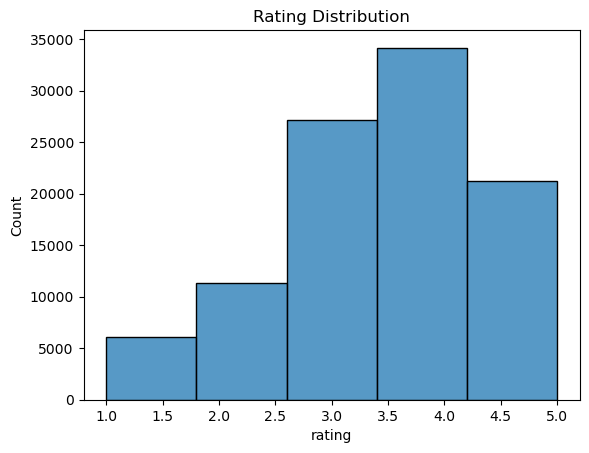

movie_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
dtype: int64


In [68]:
# Rating distribution
sns.histplot(ratings['rating'], bins=5, kde=False)
plt.title("Rating Distribution")
plt.show()

# Most-rated movies
most_rated = ratings.groupby('movie_id').size().sort_values(ascending=False).head(10)
print(most_rated)

#### Create the User-Item Matrix

In [71]:
# Pivot the data to create the user-item matrix
user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

In [73]:
print(user_item_matrix.head())

movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2          4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5          4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

movie_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                               
1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5          0.0   0.0   0.0   0.0  

#### Normalize the Data

In [76]:
def standardize(row):
    new_row=(row - row.mean())/(row.max() - row.min())
    return new_row

user_item_matrix_standardize= user_item_matrix.apply(standardize)

In [78]:
user_item_matrix_standardize

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.628208,0.510923,0.7421,0.44263,0.539767,0.980276,0.484199,0.014422,0.752916,0.527678,...,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106
2,0.428208,-0.089077,-0.0579,-0.15737,-0.060233,-0.019724,-0.315801,-0.185578,-0.247084,0.327678,...,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106
3,-0.371792,-0.089077,-0.0579,-0.15737,-0.060233,-0.019724,-0.315801,-0.185578,-0.247084,-0.072322,...,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106
4,-0.371792,-0.089077,-0.0579,-0.15737,-0.060233,-0.019724,-0.315801,-0.185578,-0.247084,-0.072322,...,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106
5,0.428208,0.510923,-0.0579,-0.15737,-0.060233,-0.019724,-0.315801,-0.185578,-0.247084,-0.072322,...,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,-0.371792,-0.089077,-0.0579,-0.15737,-0.060233,-0.019724,-0.315801,-0.185578,0.752916,-0.072322,...,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106
940,-0.371792,-0.089077,-0.0579,0.24263,-0.060233,-0.019724,0.484199,0.814422,0.352916,-0.072322,...,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106
941,0.628208,-0.089077,-0.0579,-0.15737,-0.060233,-0.019724,0.484199,-0.185578,-0.247084,-0.072322,...,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106,-0.00106


#### Convert to a long format to split into train and test


In [81]:
ratings_long = ratings[['user_id', 'movie_id', 'rating']]
train_data, test_data = train_test_split(ratings_long, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 80000
Testing set size: 20000


### Choose and Build a Collaborative Filtering Model

##### Compute the User Similarity Matrix

In [85]:
# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix_standardize)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix_standardize.index, columns=user_item_matrix_standardize.index)
print(user_similarity_df)

user_id       1         2         3         4         5         6         7    \
user_id                                                                         
1        1.000000 -0.171553 -0.310506 -0.301730  0.140798  0.217034  0.252578   
2       -0.171553  1.000000  0.083406  0.148355 -0.140813 -0.050435 -0.255074   
3       -0.310506  0.083406  1.000000  0.448948 -0.128011 -0.245160 -0.321217   
4       -0.301730  0.148355  0.448948  1.000000 -0.120693 -0.258083 -0.305829   
5        0.140798 -0.140813 -0.128011 -0.120693  1.000000 -0.028745  0.129126   
...           ...       ...       ...       ...       ...       ...       ...   
939     -0.181064  0.160643  0.075065  0.080719 -0.080885 -0.162021 -0.212341   
940      0.009340 -0.005318 -0.022683  0.009800 -0.006511  0.073813  0.028901   
941     -0.265128  0.112881  0.244181  0.291685 -0.043512 -0.225676 -0.391526   
942     -0.112166  0.011790  0.040082  0.074352 -0.048235  0.081377  0.008112   
943      0.169249 -0.161850 

#### Make Recommendations Using Similar Users

In [88]:
import numpy as np

# Adjusted function to get top N similar users
def get_top_n_similar_users(user_id, n=50):
    # Sort users by similarity score
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index.tolist()
    similar_users.remove(user_id)  # Exclude the user itself
    return similar_users[:n]

# Adjusted function to include movie titles in recommendations
def recommend_movies_for_user(user_id, n_recommendations=10):
    # Find top similar users
    similar_users = get_top_n_similar_users(user_id)
    # Gather ratings from these similar users
    similar_users_ratings = user_item_matrix_standardize.loc[similar_users]
    # Calculate the average rating for each movie
    avg_ratings = similar_users_ratings.mean(axis=0)
    # Filter out movies the user has already rated
    movies_watched = user_item_matrix_standardize.loc[user_id] > 0
    recommendations = avg_ratings[~movies_watched].sort_values(ascending=False).head(n_recommendations)

    # Convert recommendations to a DataFrame and label the average rating column
    recommendations_df = recommendations.reset_index().rename(columns={0: 'average_rating'})
    # Merge with the movies DataFrame to add titles
    recommendations_with_titles = recommendations_df.merge(movies, on='movie_id')[['title', 'movie_id', 'average_rating']]
    
    return recommendations_with_titles

# Example recommendation for a user with movie titles
#user_id = 1  # Change this to the ID of the user you want to recommend for
recommendations = recommend_movies_for_user(user_id=1,n_recommendations=20)
print(recommendations)


                                                title  movie_id  \
0                                  Stand by Me (1986)       655   
1   Dr. Strangelove or: How I Learned to Stop Worr...       474   
2                                     Heathers (1989)       433   
3                   E.T. the Extra-Terrestrial (1982)       423   
4                                       Batman (1989)       403   
5                                  Real Genius (1985)       746   
6                                        Speed (1994)       568   
7                                    True Lies (1994)       385   
8                                  Bob Roberts (1992)       425   
9                                     Clueless (1995)       367   
10                                       Glory (1989)       651   
11                              Close Shave, A (1995)       408   
12                  Jackie Chan's First Strike (1996)       455   
13             One Flew Over the Cuckoo's Nest (1975)       35

#### Evaluate the Mode

In [91]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE only if actual_ratings and predicted_ratings are not empty
def evaluate_recommendations(user_id):
    actual_ratings = []
    predicted_ratings = []
    
    # Get list of movies rated by the user
    user_rated_movies = user_item_matrix_standardize.loc[user_id].dropna()
    
    # Iterate through the movies rated by the user
    for movie_id, actual_rating in user_rated_movies.items():
        # Get the predicted rating from similar users
        similar_users = get_top_n_similar_users(user_id)
        similar_users_ratings = user_item_matrix_standardize.loc[similar_users, movie_id].dropna()
        
        # Check if there are ratings available from similar users
        if not similar_users_ratings.empty:
            predicted_rating = similar_users_ratings.mean()
            predicted_ratings.append(predicted_rating)
            actual_ratings.append(actual_rating)
    
    # Calculate RMSE only if we have ratings in both lists
    if actual_ratings and predicted_ratings:
        rmse = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
        print(f"RMSE: {rmse}")
    else:
        print("No common movies between user and similar users, unable to calculate RMSE.")

# Example usage for a user
user_id = 1  # Replace with the user ID you want to evaluate
evaluate_recommendations(user_id=545)



RMSE: 0.15442743369100756
